In [2]:
# Checking the calibration data at a further distance
# dist = 12cm vs previous 3.4 cm

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import spinmob as s

In [9]:
'''
giving a fitter, returns an array of the fitted lorentzian1 parameters and errors in 2D array
arg: my_fitter = fit, x = integer value offset

'''
def getFits_lor(my_fitter, x):
    
    di = my_fitter.get_fit_results()
    results = [di[key] for key in di.keys()]
    
    E0 = [results[0+6*x], results[1+6*x]]
    gamma = [results[2+3*x], results[3+6*x]]
    A = [results[4+3*x], results[+6*x]]
    B = [results[6+3*x], results[7+6*x]]
    
    return [E0, gamma, A, B]

'''
folds data on to first 256 channels (LHS<-RHS)
returns: array of [yData, yErrors]

This might not be working well
Should maybe take a center/deal with not integer bins
'''
def fold(data_c, dataE):
    center = 256
    data = []
    dataErr = []
    
    for i in range(0, center):
        data.append(data_c[i]+data_c[511-i])
#         print(i, 511-i)
        dataErr.append(np.sqrt(dataE[i]+dataE[511-i]))
    
    return [data, dataErr]

"""
Takes array of channels, and m, b of linear function
Returns array of velocities [mmsec]
"""
def chan_to_velo(channels, m, b):
    v = [m[0]*c + b[0] for c in channels]
#     vE = 
    
    return v

"""
"""
def average(a, b, offset):
    
    center = (a[0] - b[0]) / 2.0 + offset[0]
    err = np.sqrt((np.sqrt((a[1])**2 + (b[1])**2)*0.5)**2+(offset[1])**2)
    
    return [center, err]
    

#one lorentzians with offset
def lorentzian(E, E0, gamma, A, b):
    denom = (E-E0)**2 + (gamma/2)**2
    return A*gamma**2/denom + b

#2 lorentzians added together with one offset
def lorentzian2(E, E0, gamma, A, E0_2, gamma_2, A_2, b):
    denom = (E-E0)**2 + (gamma/2)**2
    denom_2 = (E-E0_2)**2 + (gamma_2/2)**2

    return A*gamma**2/denom + A_2*gamma_2**2/denom_2 + b

#6 lorentzians added together with one offset
def lorentzian6(E, E0, gamma, A, E0_2, gamma_2, A_2, E0_3, gamma_3, A_3, E0_4, gamma_4, A_4, E0_5, gamma_5, A_5, E0_6, gamma_6, A_6, b):
    denom = (E-E0)**2 + (gamma/2)**2
    denom_2 = (E-E0_2)**2 + (gamma_2/2)**2
    denom_3 = (E-E0_3)**2 + (gamma_3/2)**2
    denom_4 = (E-E0_4)**2 + (gamma_4/2)**2
    denom_5 = (E-E0_5)**2 + (gamma_5/2)**2
    denom_6 = (E-E0_6)**2 + (gamma_6/2)**2

    return A*gamma**2/denom + A_2*gamma_2**2/denom_2 + A_3*gamma_3**2/denom_3 + A_4*gamma_4**2/denom_4 + A_5*gamma_5**2/denom_5 + A_6*gamma_6**2/denom_6 + b

# def ChiS(expectX, obs, para): #maybe for checking the crazy big chi squared
#     hi = []
#     for x in range(0, len(obs)):
#         val = (obs[x] - lorentzian(expectX, para[], para[],) )**2/
#         hi.append(val)
    
    

# Fitting folded calibration data 
REALLY big chi squared wtf

In [10]:
#loading
data = np.loadtxt(".//data//ironfoil_longerdistance_Jan20_full.Asc", skiprows=0)

data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2 #last channel is oddly low so extrapolate from side two bins
ydataerr = np.sqrt(data[1])

#folding the data
foldD = fold(data[1], ydataerr)
foldedData = [data[0][0:256], foldD[0], foldD[1]]

#for velocity matching later
#literature values (from 1-6), (mm/sec)
#Cite as: Journal of Applied Physics 42, 4339 (1971); https://doi.org/10.1063/1.1659777
litValCal = [-5.4823, -3.2473, -1.0132, 0.6624, 2.8967, 5.1338]
litValCalE = [0.0008, 0.0008, 0.0010, 0.0007, 0.0007, 0.0010]

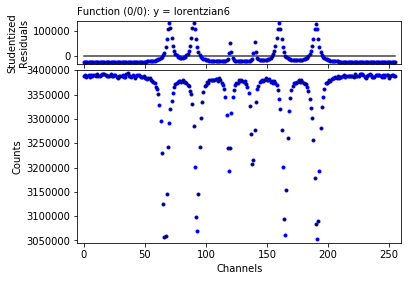

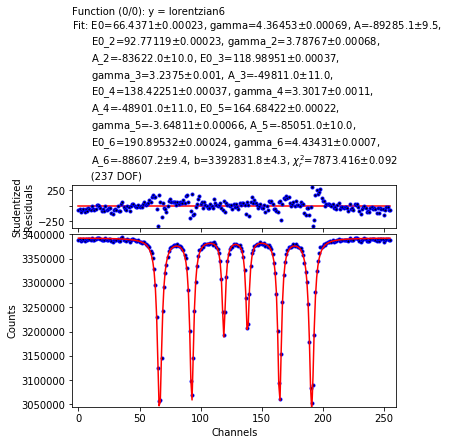


# FIT RESULTS (reduced chi squared = [7873.416239950061])
E0         = 66.4371
gamma      = 4.36453
A          = -89285.1
E0_2       = 92.7712
gamma_2    = 3.78767
A_2        = -83621.9
E0_3       = 118.99
gamma_3    = 3.23752
A_3        = -49811.4
E0_4       = 138.423
gamma_4    = 3.30172
A_4        = -48900.8
E0_5       = 164.684
gamma_5    = -3.64811
A_5        = -85051.2
E0_6       = 190.895
gamma_6    = 4.43431
A_6        = -88607.2
b          = 3.39283E+06



In [11]:
my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Channels" , ylabel = "Counts")

guess = 'E0=70,gamma=5,A=-2e6, E0_2=90, gamma_2=5, A_2=-2e6, E0_3=120, gamma_3=2, A_3=-1e6, E0_4=140, gamma_4=2, A_4=-1e6, E0_5=160, gamma_5=5, A_5=-2e6, E0_6=190, gamma_6=5, A_6=-2e6, b=4.8e6'

my_fitter.set_functions(f=lorentzian6, p=guess)

my_fitter.set_data(xdata=foldedData[0], ydata=foldedData[1], eydata=foldedData[2])
my_fitter.fit()
my_fitter.print_fit_parameters()


In [12]:
# my_fitter.results
# x = my_fitter.get_fit_results()
# results = x.values()

# results = [x[key] for key in x.keys()]

# print(results)
# # print(x['E0.std'])
# print(type(results))

# ironfoil_longerdistance_Jan20_full

### Fitting unfolded calibration data 

In [13]:
# data = np.loadtxt(".//data//ironfoil_longerdistance_Jan20_full.Asc", skiprows=0)

# data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])


dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]
dataR = [data[0][256:512], data[1][256:512], ydataerr[256:512]]

print(len(dataR[0]), len(dataL[0]))
# data[0][511]

256 256


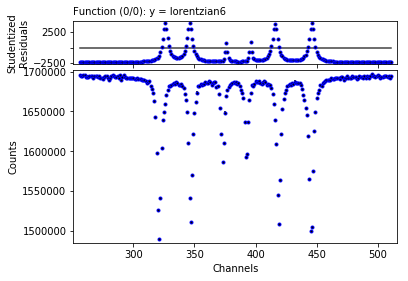

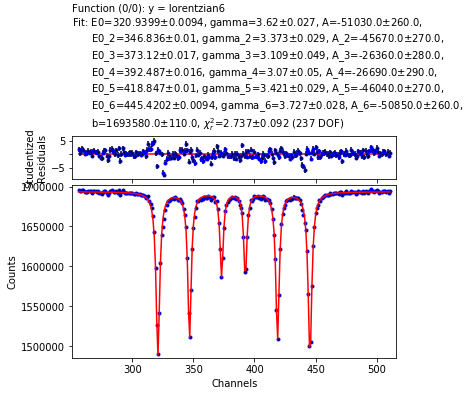


# FIT RESULTS (reduced chi squared = [2.737203002017345])
E0         = 320.94
gamma      = 3.62025
A          = -51031.7
E0_2       = 346.836
gamma_2    = 3.37337
A_2        = -45673.3
E0_3       = 373.12
gamma_3    = 3.10947
A_3        = -26362.1
E0_4       = 392.487
gamma_4    = 3.06964
A_4        = -26686.5
E0_5       = 418.847
gamma_5    = 3.42054
A_5        = -46039.5
E0_6       = 445.42
gamma_6    = 3.72722
A_6        = -50846.3
b          = 1.69358E+06



In [14]:
my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Channels" , ylabel = "Counts")

guess = 'E0=326,gamma=5,A=-2e6, E0_2=346, gamma_2=5, A_2=-2e6, E0_3=376, gamma_3=2, A_3=-1e6, E0_4=396, gamma_4=2, A_4=-1e6, E0_5=416, gamma_5=5, A_5=-2e6, E0_6=446, gamma_6=5, A_6=-2e6, b=4.8e6'

my_fitter.set_functions(f=lorentzian6, p=guess)

my_fitter.set_data(xdata=dataR[0], ydata=dataR[1], eydata=dataR[2])
my_fitter.fit()
my_fitter.print_fit_parameters()

resultsRS = getFits_lor(my_fitter, 5)

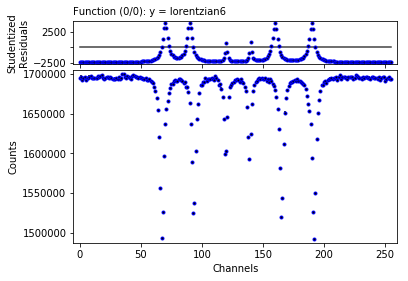

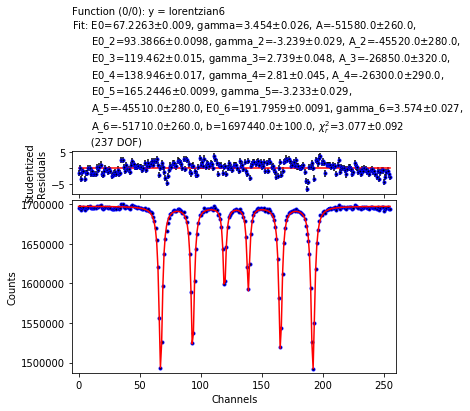

In [15]:
my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Channels" , ylabel = "Counts")

guess = 'E0=70,gamma=5,A=-2e6, E0_2=90, gamma_2=5, A_2=-2e6, E0_3=120, gamma_3=2, A_3=-1e6, E0_4=140, gamma_4=2, A_4=-1e6, E0_5=160, gamma_5=5, A_5=-2e6, E0_6=190, gamma_6=5, A_6=-2e6, b=4.8e6'

my_fitter.set_functions(f=lorentzian6, p=guess)

my_fitter.set_data(xdata=dataL[0], ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()
# print(my_fitter.get_fit_results())

resultsLS = getFits_lor(my_fitter, 0)



In [16]:
#checking center of Cal data
cent = average(resultsRS[0], resultsLS[0], resultsLS[0])

print(cent)

[256.3232191873547, 0.011122057411679794]


# Trying to Match Peaks and velocities
Velocities are from Journal of Applied Physics 42, 4339 (1971); https://doi.org/10.1063/1.1659777  
Currently only using LS of data, we don't really know the right direction yet requires isomer shift).

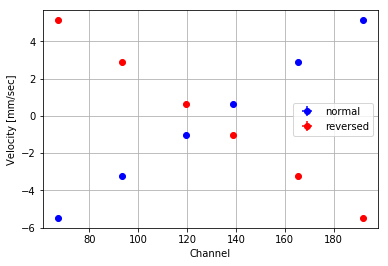

In [17]:
#matching to lit. values
peaksL = [getFits_lor(my_fitter, 0)[0][0], getFits_lor(my_fitter, 1)[0][0], getFits_lor(my_fitter, 2)[0][0], getFits_lor(my_fitter, 3)[0][0], getFits_lor(my_fitter, 4)[0][0], getFits_lor(my_fitter, 5)[0][0] ]
peaksLEr = [getFits_lor(my_fitter, 0)[0][1], getFits_lor(my_fitter, 1)[0][1], getFits_lor(my_fitter, 2)[0][1], getFits_lor(my_fitter, 3)[0][1], getFits_lor(my_fitter, 4)[0][1], getFits_lor(my_fitter, 5)[0][1] ]

peaksRev = [getFits_lor(my_fitter, 0)[0][0], getFits_lor(my_fitter, 1)[0][0], getFits_lor(my_fitter, 2)[0][0], getFits_lor(my_fitter, 3)[0][0], getFits_lor(my_fitter, 4)[0][0], getFits_lor(my_fitter, 5)[0][0] ]
peaksRevEr = [getFits_lor(my_fitter, 0)[0][1], getFits_lor(my_fitter, 1)[0][1], getFits_lor(my_fitter, 2)[0][1], getFits_lor(my_fitter, 3)[0][1], getFits_lor(my_fitter, 4)[0][1], getFits_lor(my_fitter, 5)[0][1] ]

peaksRev.reverse() 
peaksRevEr.reverse() 

plt.errorbar(peaksL, litValCal, yerr=litValCalE, xerr=peaksLEr, color='b', label='normal', linestyle='', marker='o')
plt.errorbar(peaksRev, litValCal, yerr=litValCalE, xerr=peaksRevEr, color='r', label='reversed', linestyle='', marker='o')

plt.grid()
plt.ylabel('Velocity [mm/sec]')
plt.xlabel('Channel')
plt.legend()
plt.show()

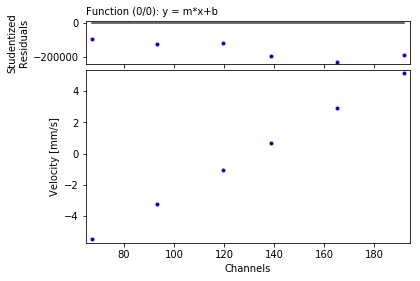

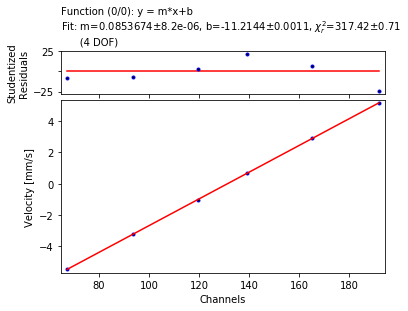


SETTINGS
  autoplot        True
  coarsen         [1]
  first_figure    0
  fpoints         [None]
  plot_all_data   [False]
  plot_bg         [True]
  plot_errors     [True]
  plot_fit        [True]
  plot_guess      [False]
  plot_guess_zoom [False]
  scale_eydata    [1.0]
  silent          False
  style_bg        [{'marker': '', 'color': 'k', 'ls': '-'}]
  style_data      [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]
  style_fit       [{'marker': '', 'color': 'r', 'ls': '-'}]
  style_guess     [{'marker': '', 'color': '0.25', 'ls': '-'}]
  subtract_bg     [False]
  xlabel          ['Channels']
  xmax            [None]
  xmin            [None]
  xscale          ['linear']
  ylabel          ['Velocity [mm/s]']
  ymax            [None]
  ymin            [None]
  yscale          ['linear']

GUESS (reduced chi^2 = 41850530980.72 +/- 0.71, 4.0 DOF)
  m          = 1.0
  b          = 1.0

FIT RESULTS (reduced chi^2 = 317.42 +/- 0.71, 4 DOF)
  m          = 0.0853674 +/- 8.2e-06


In [18]:
my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Channels" , ylabel = "Velocity [mm/s]")
my_fitter.set_functions(f='m*x+b', p='m, b')
my_fitter.set_data(xdata=peaksL, ydata=litValCal, eydata=litValCalE, exdata=peaksLEr)
my_fitter.fit()
# my_fitter.print_fit_parameters()

In [19]:
# def getFits_lor(my_fitter, x):
    
#     di = my_fitter.get_fit_results()
#     results = [di[key] for key in di.keys()]
    
#     E0 = [results[0+6*x], results[1+6*x]]
#     gamma = [results[2+3*x], results[3+6*x]]
#     A = [results[4+3*x], results[+6*x]]
#     B = [results[6+3*x], results[7+6*x]]
    
#     return [E0, gamma, A, B]

di = my_fitter.get_fit_results()
results = [di[key] for key in di.keys()]
m = [results[0], results[1]]
b = [results[2], results[3]]

#looking at redifining the zero velocity using the center of the cal peaks
## CHECK if we should do this
new00 = average([peaksL[3],peaksLEr[3]],[peaksL[2],peaksLEr[2]],[peaksL[2],peaksLEr[2]])
new01 = average([peaksL[4],peaksLEr[4]],[peaksL[1],peaksLEr[1]],[peaksL[1],peaksLEr[1]])
new02 = average([peaksL[5],peaksLEr[5]],[peaksL[0],peaksLEr[0]],[peaksL[0],peaksLEr[0]])

print(new00, new01, new02)

#different between linear fit to zero and center of peaks
print(chan_to_velo([129], m, b))

[129.20361512128108, 0.018877964552207884] [129.31561317813217, 0.012037899309224151] [129.5111071589785, 0.011061758660945793]
[-0.20197085757143007]


In [20]:
#reversed fit
# my_fitter = s.data.fitter()
# my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
#               , plot_guess=False, fpoints=None)
# # help(s.data.fitter)
# my_fitter.set_functions(f='m*x+b', p='m, b')
# my_fitter.set_data(xdata=peaksRev, ydata=litValCal, eydata=litValCalE, exdata=peaksRevEr)
# my_fitter.fit()

## Testing with stainless steel data 
This only has one peak so it's easy to see things with

In [21]:
#testing with stainlessSteel data which only has one peak
data = np.loadtxt(".//data//StainlessSteelFoil_Jan13_fullData.Asc", skiprows=0)

data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]


#folding the data
foldD = fold(data[1], ydataerr)
foldedData = [data[0][0:256], foldD[0], foldD[1]]

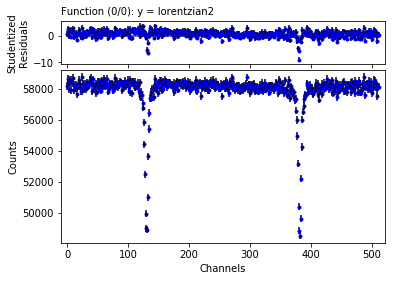

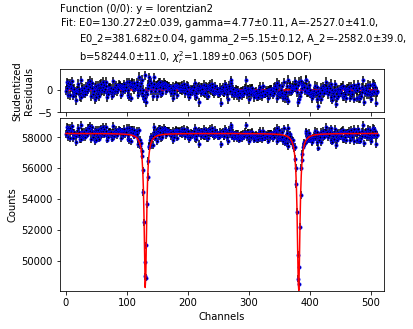


# FIT RESULTS (reduced chi squared = [1.1892902065667164])
E0         = 130.272
gamma      = 4.77292
A          = -2526.55
E0_2       = 381.682
gamma_2    = 5.14889
A_2        = -2582.1
b          = 58244



In [22]:
# lorentzian2 - for fitting 2
my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Channels" , ylabel = "Counts")
# help(s.data.fitter)

my_fitter.set_functions(f=lorentzian2, p='E0=130,gamma=5,A=-2300,E0_2=382,gamma_2=5,A_2=-2300,b=58000')
my_fitter.set_data(xdata=data[0], ydata=data[1], eydata=ydataerr)
my_fitter.fit()
my_fitter.print_fit_parameters()


In [23]:
# # fitLS, fitRS - checking center of SS

# center = (fitRS[0][0] - fitLS[0][0]) / 2.0 + fitLS[0][0]
# print(center)

# 512/2

# output:
# 255.97671345493336

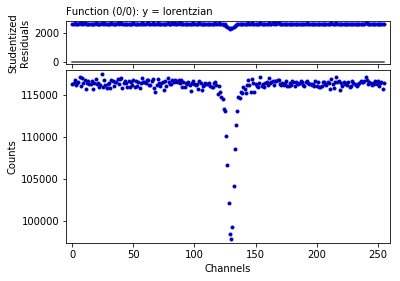

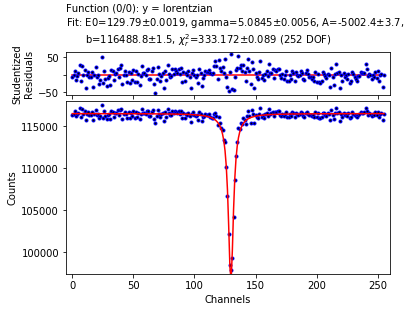


# FIT RESULTS (reduced chi squared = [333.17247321845593])
E0         = 129.79
gamma      = 5.08449
A          = -5002.45
b          = 116489



In [24]:
#512 channels - fitting folded data
my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Channels" , ylabel = "Counts")
# help(s.data.fitter)
my_fitter.set_functions(f=lorentzian, p='E0=130,gamma=5,A=-2300,b=58000')
my_fitter.set_data(xdata=foldedData[0], ydata=foldedData[1], eydata=foldedData[2])
my_fitter.fit()
my_fitter.print_fit_parameters()


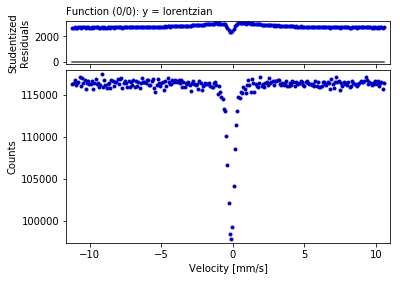

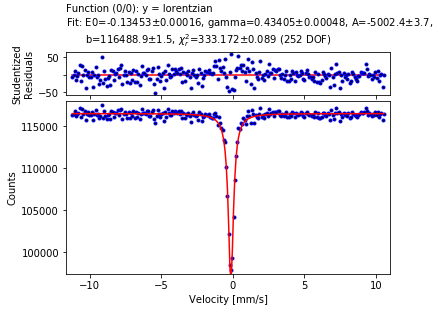


# FIT RESULTS (reduced chi squared = [333.17247326298946])
E0         = -0.134532
gamma      = 0.434053
A          = -5002.43
b          = 116489



In [25]:
#512 channels - fitting folded data
velocities = chan_to_velo(foldedData[0], m, b)

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")
# help(s.data.fitter)

my_fitter.set_functions(f=lorentzian, p='E0=0,gamma=5,A=-2300,b=58000')
my_fitter.set_data(xdata=velocities, ydata=foldedData[1], eydata=foldedData[2])
my_fitter.fit()
my_fitter.print_fit_parameters()


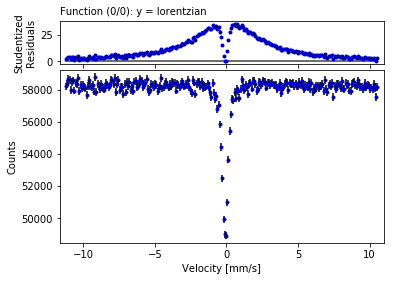

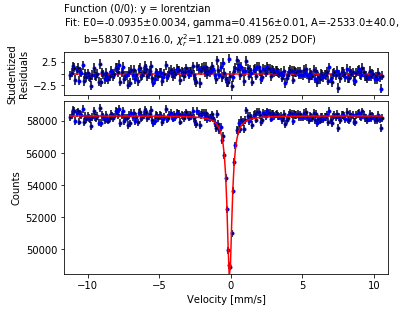


SETTINGS
  autoplot        True
  coarsen         [1]
  first_figure    0
  fpoints         [None]
  plot_all_data   [False]
  plot_bg         [True]
  plot_errors     [True]
  plot_fit        [True]
  plot_guess      [False]
  plot_guess_zoom [False]
  scale_eydata    [1.0]
  silent          False
  style_bg        [{'marker': '', 'color': 'k', 'ls': '-'}]
  style_data      [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]
  style_fit       [{'marker': '', 'color': 'r', 'ls': '-'}]
  style_guess     [{'marker': '', 'color': '0.25', 'ls': '-'}]
  subtract_bg     [False]
  xlabel          ['Velocity [mm/s]']
  xmax            [None]
  xmin            [None]
  xscale          ['linear']
  ylabel          ['Counts']
  ymax            [None]
  ymin            [None]
  yscale          ['linear']

GUESS (reduced chi^2 = 238.191 +/- 0.089, 252.0 DOF)
  E0         = 0.0
  gamma      = 5.0
  A          = -2300.0
  b          = 58000.0

FIT RESULTS (reduced chi^2 = 1.121 +/- 0.089, 252 

In [26]:
#unfolded fit - LHS of SSfoil
velocities = chan_to_velo(dataL[0], m, b)

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")
# help(s.data.fitter)

my_fitter.set_functions(f=lorentzian, p='E0=0,gamma=5,A=-2300,b=58000')

my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()
# print(my_fitter.get_fit_results())

# resultsLS = getFits_lor(my_fitter, 0)